<a href="https://colab.research.google.com/github/fudw/dice-detection-for-board-games/blob/main/dice_detection_yolov5_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dice Detection for Board Games

### *by Dawei Fu (August 2021)*

## I. Download yolov5 model and public data for pretraining

In [1]:
from google.colab import output

# clone yolov5 repo
!git clone https://github.com/ultralytics/yolov5 
!pip install -r yolov5/requirements.txt

# download dataset from https://public.roboflow.com/object-detection/dice/
!wget https://public.roboflow.com/ds/VdKh306UT4?key=4OgEXgYGDp
!unzip VdKh306UT4?key=4OgEXgYGDp
output.clear()
!echo "Data downloaded!"

Data downloaded!


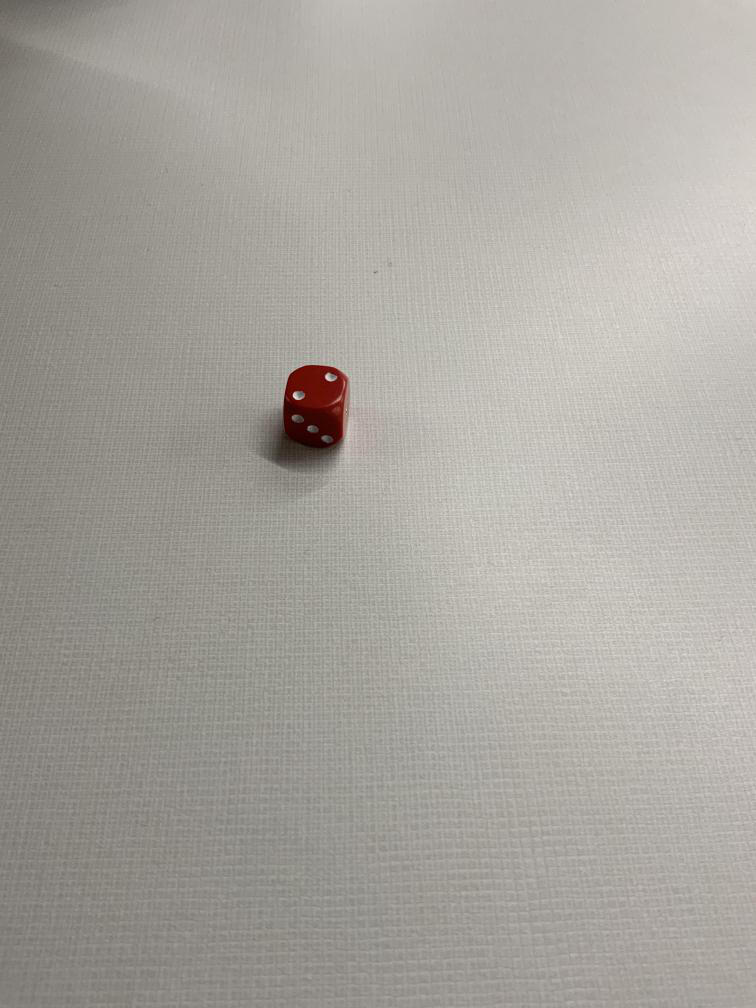

In [2]:
from PIL import Image

# take a look at an image
Image.open('export/images/0BrzNN9qMnzQlQPZ1sso.jpg')

## II. Exploratory data analysis

In [3]:
! pip install --upgrade albumentations
output.clear()

# import ALL the things
import os
import numpy as np
import pandas as pd
import random
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from matplotlib import pyplot as plt
import yaml
from shutil import copyfile

seed = 9
random.seed(seed)

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 CPU


In [4]:
os.listdir()

['.config',
 'export',
 'README.dataset.txt',
 'VdKh306UT4?key=4OgEXgYGDp',
 'README.roboflow.txt',
 'yolov5',
 'data.yaml',
 'sample_data']

In [5]:
os.rename('export', 'dice_dataset')
root = os.path.abspath('dice_dataset')
image_dir = os.path.join(root, 'images')
label_dir = os.path.join(root, 'labels')

In [6]:
image_names = list(sorted(os.listdir(image_dir)))
label_names = list(sorted(os.listdir(label_dir)))

In [7]:
print(len(image_names))

718


In [8]:
with open("data.yaml", 'r') as file:
  yaml_file = yaml.load(file)
print(yaml_file)
class_labels = yaml_file['names']
print(class_labels)

{'train': '../train/images', 'val': '../valid/images', 'nc': 6, 'names': ['1', '2', '3', '4', '5', '6']}
['1', '2', '3', '4', '5', '6']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [11]:
train_val_split = 0.9
train_image_names = sorted(random.sample(image_names, int(len(image_names) * train_val_split)))
val_image_names = sorted(list(set(image_names) - set(train_image_names)))
print(f'training set has {len(train_image_names)} images')
print(f'validation set has {len(val_image_names)} images')

training set has 646 images
validation set has 72 images


In [12]:
print(image_names[0][:-4])

0BrzNN9qMnzQlQPZ1sso


In [13]:
label_file = os.path.join(label_dir, label_names[0])
with open(label_file, 'r') as file:
  targets = file.read()
targets = targets.split('\n')
targets

['1 0.4174933862433862 0.3835565476190476 0.08167989417989419 0.043402777777777776']

In [14]:
col = ['image_id', 'class', 'centre_x', 'centre_y', 'width', 'height']
image_df = pd.DataFrame(columns = col)
image_df

,image_id,class,centre_x,centre_y,width,height


In [15]:
row = {}
row[col[0]] = label_names[0][:-4]
for i, t in enumerate(targets[0].split(' ')):
  row[col[i+1]] = float(t)
row

{'centre_x': 0.4174933862433862,
 'centre_y': 0.3835565476190476,
 'class': 1.0,
 'height': 0.043402777777777776,
 'image_id': '0BrzNN9qMnzQlQPZ1sso',
 'width': 0.08167989417989419}

In [16]:
image_df.append(row, ignore_index = True)

,image_id,class,centre_x,centre_y,width,height
0,0BrzNN9qMnzQlQPZ1sso,1.0,0.417493,0.383557,0.08168,0.043403


In [17]:
def get_targets(label_name):
  
  label_file = os.path.join(label_dir, label_name)
  with open(label_file, 'r') as file:
    targets = file.read()
  
  return targets.split('\n')

def get_row(label_name, targets, col):
  
  row = {}
  row[col[0]] = label_name[:-4]
  for i, t in enumerate(targets.split(' ')):
    row[col[i+1]] = float(t)
  
  return row

def add_targets_to_df(df, label_name):
  
  targets = get_targets(label_name)
  for target in targets:
    row = get_row(label_name, target, df.columns)
    df = df.append(row, ignore_index = True)
  
  return df

def create_image_df_with_labels(col, label_names):
  
  df = pd.DataFrame(columns = col)
  for name in label_names:
    df = add_targets_to_df(df, name)
  
  return df


In [18]:
raw_df = create_image_df_with_labels(col, label_names)
raw_df

,image_id,class,centre_x,centre_y,width,height
0,0BrzNN9qMnzQlQPZ1sso,1.0,0.417493,0.383557,0.081680,0.043403
1,0kpaB4UeoohBVODkOmGd,3.0,0.389385,0.640625,0.034061,0.023313
2,0kpaB4UeoohBVODkOmGd,5.0,0.675430,0.340278,0.024802,0.014385
3,0thII0LnXrzeDTZ6HbiS,3.0,0.528935,0.426711,0.081680,0.045387
4,1W3kCdCcSnq0jkQiZZ00,5.0,0.537822,0.501157,0.019593,0.029431
...,...,...,...,...,...,...
1929,zcDdJ83uFyJdnSy8ITcG,0.0,0.473380,0.667287,0.031415,0.020089
1930,zdYhuzHS1d5dtxnIkb5H,2.0,0.630622,0.483507,0.039683,0.031002
1931,zdYhuzHS1d5dtxnIkb5H,0.0,0.596726,0.384797,0.042659,0.031994
1932,zoYU94l6w95JmizBxoS7,1.0,0.661376,0.549355,0.042328,0.032242


### Experiment with data augmentation

In [19]:
def get_label_and_boxes(image_id, df):

  rows = df[df.image_id == image_id[:-4]]

  return rows['class'].values, rows[box_cols].values

In [20]:
box_cols = col[-4:]
box_cols

['centre_x', 'centre_y', 'width', 'height']

In [21]:
class dice_pretrain_dataset(torch.utils.data.Dataset):

  def __init__(self, root, image_ids, df, transforms = None):

    super().__init__()
    self.root = root
    self.image_ids = image_ids
    self.df = df
    self.transforms = transforms

  def __len__(self):

    return len(self.image_ids)

  def __getitem__(self, idx):

    image_id = self.image_ids[idx]
    image_path = os.path.join(image_dir, image_id)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    target = {}
    labels, boxes = get_label_and_boxes(image_id, self.df)
    areas = boxes[:,2] * boxes[:, 3]
    iscrowd = torch.zeros((len(labels),))
    image_id = torch.tensor([idx])
    labels = torch.as_tensor(labels, dtype = torch.float32)
    boxes = torch.as_tensor(boxes, dtype = torch.float32)
    areas = torch.as_tensor(areas, dtype = torch.float32)
    target['boxes'] = boxes
    target['labels'] = labels
    target['areas'] = areas
    target['iscrowd'] = iscrowd
    target['image_id'] = image_id

    if self.transforms is not None:
      transformed = self.transforms(image = img, bboxes = target['boxes'], class_labels = target['labels'])
      img = transformed['image']
      target['boxes'] = transformed['bboxes']
      target['labels'] = transformed['class_labels']
      
    return img, target
    

In [ ]:
#@title old draw boxes
def draw_bbox(box, img_width, img_height, color = 'green'):

  rectangle = plt.Rectangle((img_width*box[0]-0.5*img_width*box[2], img_height*box[1]-0.5*img_height*box[3]), 
                            img_width*box[2], img_height*box[3], color = color, fill = False, lw = 3)
  return rectangle

def show_bboxes(img, bb):
  plt.figure(figsize = (14, 20))
  plt.imshow(img)
  boxes = np.array(bb, dtype = np.float32)
  print(boxes.shape)
  for box in list(boxes):
    plt.gca().add_patch(draw_bbox(box, img.width, img.height))

In [22]:
def visualise_bbox(img, bbox, class_name, colour=(0, 205, 0), thickness=2):
  """Draws a single bounding box with label on the image"""

  img = np.transpose(img.numpy(), (1, 2, 0))
  img_w, img_h = img.shape[1], img.shape[0]
  x_centre, y_centre, w, h = bbox
  x_min, x_max, y_min, y_max = int(img_w * (x_centre - 0.5 * w)), int(img_w * (x_centre + 0.5 * w)), int(img_h * (y_centre - 0.5 * h)), int(img_h * (y_centre + 0.5 * h))
  cv2.rectangle(img, (x_min, y_min), (x_max, y_max), colour, thickness)
  ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 1)    
  cv2.rectangle(img, (x_min, y_min - int(1.5 * text_height)), ((x_min + text_width), y_min), colour, -1)
  cv2.putText(
      img,
      text=class_name,
      org=(x_min, y_min - int(0.3 * text_height)),
      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
      fontScale=0.8, 
      color=(255, 255, 255), 
      lineType=cv2.LINE_AA,
      thickness=2
  )
  return img

def visualise(image, bboxes, class_ids):
  """Visualises an image with bounding boxes on it"""
  
  for bbox, class_id in zip(bboxes, list(class_ids)):
      img = visualise_bbox(image, bbox, str(int(class_id)+1))
  plt.figure(figsize=(7, 10))
  #plt.axis('off')
  plt.imshow(img)

In [23]:
crop_dim = 512
def get_transforms(istrain):
  transforms = []
  if istrain:
    transforms.append(A.HorizontalFlip(p = 0.5))
    transforms.append(A.VerticalFlip(p = 0.5))
    transforms.append(A.RandomCrop(width = crop_dim, height = crop_dim))
  transforms.append(A.CenterCrop(width = crop_dim, height = crop_dim))
  transforms.append(ToTensorV2())
  return A.Compose(transforms, bbox_params = A.BboxParams(format = 'yolo', min_area = 200, min_visibility = 0.5, label_fields = ['class_labels']))

In [24]:
train_dice_ds = dice_pretrain_dataset(root, image_names, raw_df, get_transforms(True))
val_dice_ds = dice_pretrain_dataset(root, image_names, raw_df, get_transforms(False))

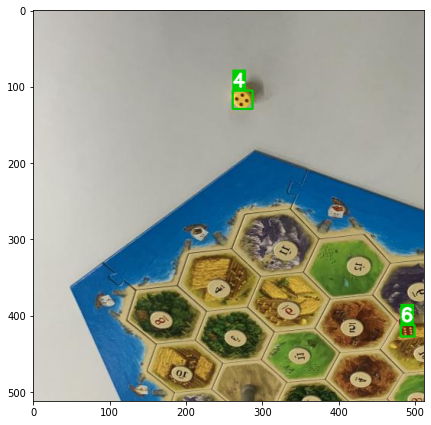

In [25]:
idx = 1
train_preview = train_dice_ds[idx]
visualise(train_preview[0], train_preview[1]['boxes'], train_preview[1]['labels'])

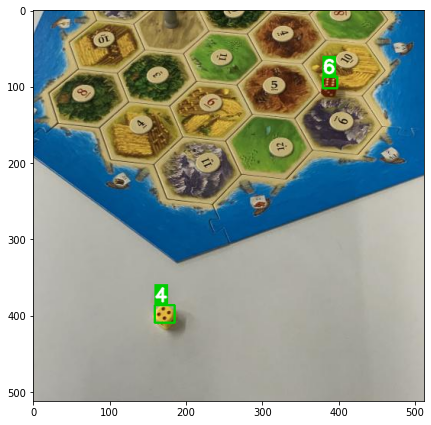

In [26]:
idx = 1
val_preview = val_dice_ds[idx]
visualise(val_preview[0], val_preview[1]['boxes'], val_preview[1]['labels'])

## III. Prepare data for yolov5

In [27]:
os.mkdir('data')
os.mkdir('data/images')
os.mkdir('data/images/train')
os.mkdir('data/images/valid')
os.mkdir('data/labels')
os.mkdir('data/labels/train')
os.mkdir('data/labels/valid')

In [28]:
def copyfile_train_val(df, origin_dir, destination_dir, val_split=0.2):
  '''Copy files into train and validation directories'''

  for image_id in list(set(df.image_id)):
    image_origin =  origin_dir + '/images/'+image_id+'.jpg'
    label_origin =  origin_dir + '/labels/'+image_id+'.txt'

    #print(os.path.join(origin_dir, 'images/'+image_id+'.jpg'))
    if random.random() > val_split:
      image_desti = os.path.join(destination_dir, 'images/train/'+image_id+'.jpg')
      label_desti = os.path.join(destination_dir, 'labels/train/'+image_id+'.txt')
    else:
      image_desti = os.path.join(destination_dir, 'images/valid/'+image_id+'.jpg')
      label_desti = os.path.join(destination_dir, 'labels/valid/'+image_id+'.txt')

    #print(image_desti)
    #print(label_desti)
    copyfile(image_origin, image_desti)
    copyfile(label_origin, label_desti)

In [29]:
origin_dir = 'dice_dataset'
destination_dir = 'data'

copyfile_train_val(raw_df, origin_dir, destination_dir, val_split=0.2)

In [30]:
with open('new_train_yaml', 'w+') as file:
    file.write(
        """
        # parameters
        nc: 6  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )


In [77]:
new_data_yaml = yaml_file
new_data_yaml['train'] = os.path.join(os.getcwd(), destination_dir, 'images/train')
new_data_yaml['val'] = os.path.join(os.getcwd(), destination_dir, 'images/valid')
new_data_yaml = '\n'.join([f'{list(new_data_yaml.keys())[i]}: {list(new_data_yaml.values())[i]}' 
                           for i in range(len(new_data_yaml))])
print(new_data_yaml)
with open("new_data.yaml", 'w') as file:
  file.write(str(new_data_yaml))

train: /content/data/images/train
val: /content/data/images/valid
nc: 6
names: ['1', '2', '3', '4', '5', '6']


In [78]:
with open("new_data.yaml", 'r') as file:
  print(file.read())

train: /content/data/images/train
val: /content/data/images/valid
nc: 6
names: ['1', '2', '3', '4', '5', '6']


## IV. Pre-train model on public dataset

In [79]:
os.chdir('yolov5')

In [81]:
os.getcwd()

'/content/yolov5'

In [82]:
%%time
!python train.py --img 512 --batch 8 --epochs 1 --data '/content/new_data.yaml' --cfg '/content/new_train_yaml' --weights yolov5s.pt


train: weights=yolov5s.pt, cfg=/content/new_train_yaml, data=/content/new_data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=1, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-369-g19d03a9 torch 1.9.0+cu102 CPU

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, p

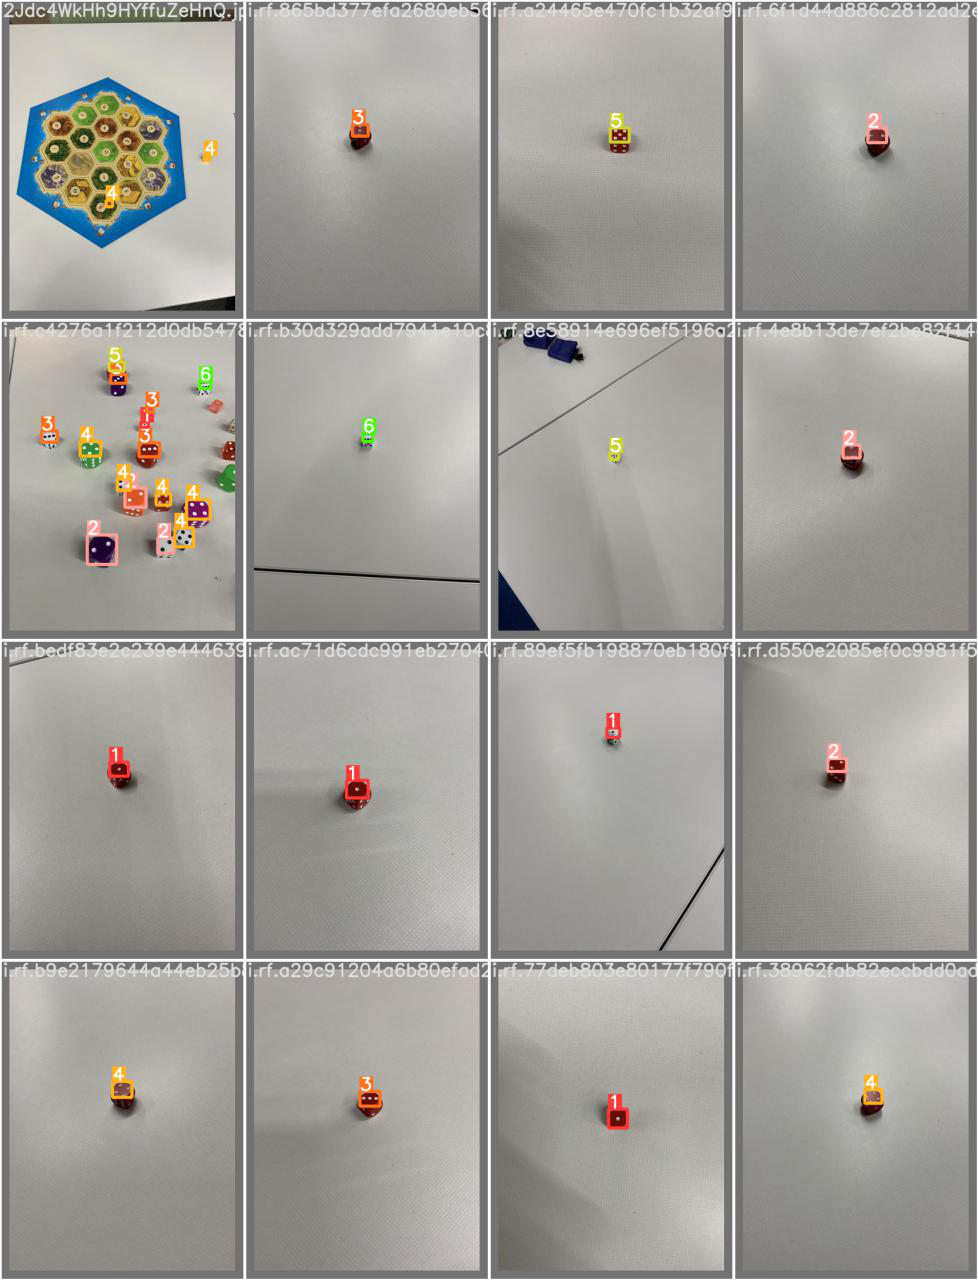

In [87]:
Image.open('/content/yolov5/runs/train/exp/val_batch0_labels.jpg')

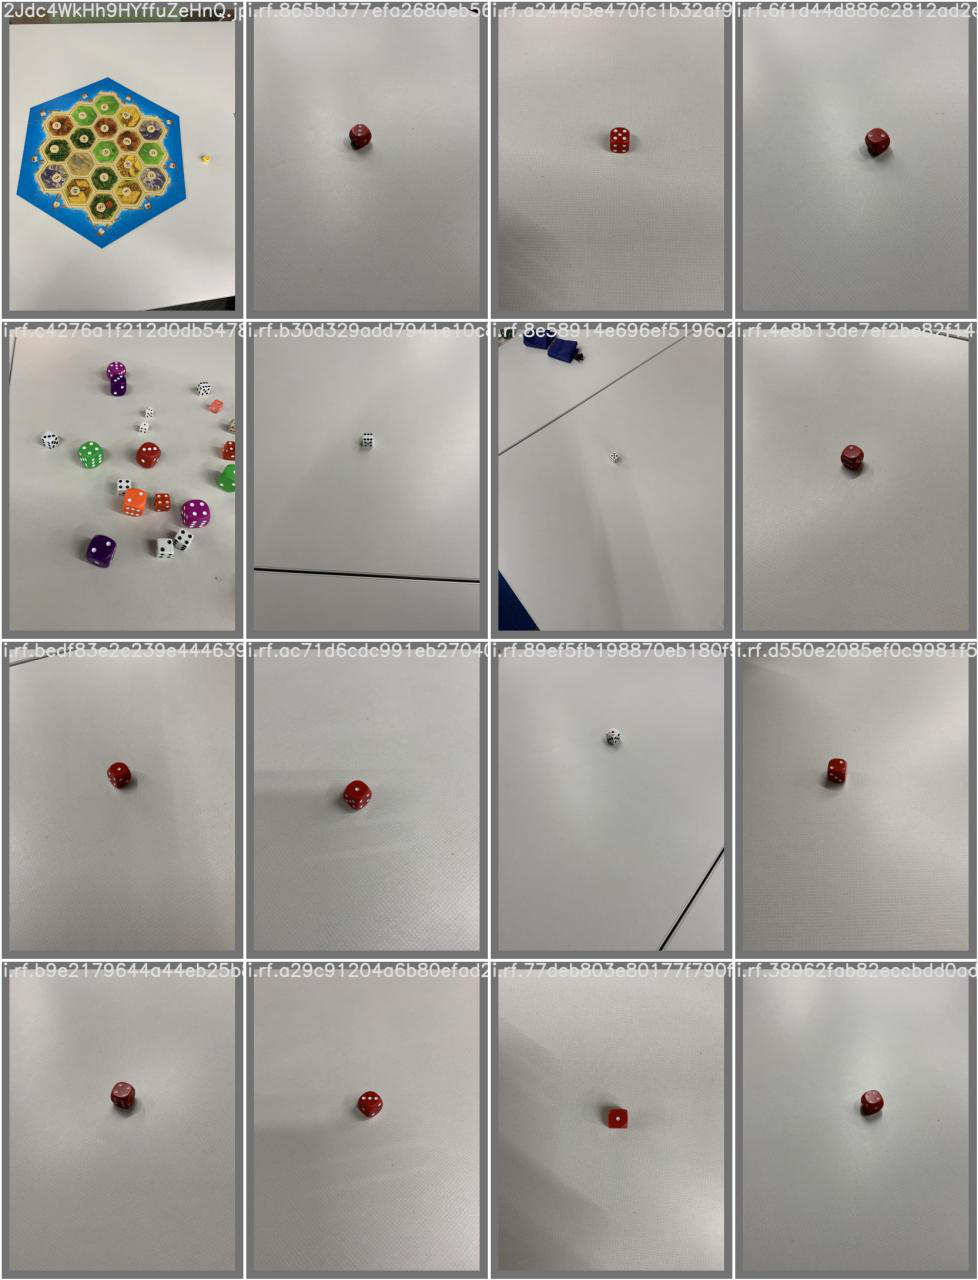

In [88]:
Image.open('/content/yolov5/runs/train/exp/val_batch0_pred.jpg')